# Text Data Explanation Benchmarking: Emotion Multiclass Classification

This notebook demonstrates how to use the benchmark utility to benchmark the performance of an explainer for text data. In this demo, we showcase explanation performance for partition explainer on an Emotion Multiclass Classification model. The metrics used to evaluate are "keep positive" and "keep negative". The masker used is Text Masker.

The new benchmark utility uses the new API with MaskedModel as wrapper around user-imported model and evaluates masked values of inputs.

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import shap.benchmark as benchmark
import shap
import scipy as sp
import datasets
import torch
import time

data = datasets.load_dataset("imdb", split="train")

tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

# set mapping between label and id
# id2label = model.config.id2label
# label2id = model.config.label2id
# labels = sorted(label2id, key=label2id.get)

def f_str(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64)
    outputs = model(tv, attention_mask=attention_mask, output_attentions=True)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val
def f_str_positive(x):
    return f_str(x)[:, 1]

def f_ids(x):
    max_length = 128
    xt = torch.zeros(len(x), max_length, dtype=torch.int)
    for i in range(len(x)):
        l = min(max_length, len(x[i]))
        xt[i, :l] = torch.tensor(x[i][:max_length])
        xt[i, l-1] = 102 # end with ending tag
    tv = xt.cuda()
    attention_mask = (tv!=0).type(torch.int64)
    outputsa = model(tv, attention_mask=attention_mask, output_attentions=True)
    outputs = outputsa[0].detach().cpu()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val
def f_ids_positive(x):
    return f_ids(x)[:, 1]

masker_zero = shap.maskers.Text(tokenizer, output_type="ids", mask_token=0)
masker_mask = shap.maskers.Text(tokenizer, output_type="ids", mask_token=103)

explainer_zero = shap.Explainer(f_ids_positive, masker_zero)
explainer_mask = shap.Explainer(f_ids_positive, masker_mask)
explainer_rand = shap.explainers.other.Random(f_ids_positive, masker_mask)

# shap_values_raw = explainer_raw(data["text"][:1])

inds = np.arange(data.shape[0])
np.random.seed(0)
np.random.shuffle(inds)

        
cmasker_zero = shap.maskers.Composite(explainer_zero.masker, shap.maskers.Fixed())
cmasker_mask = shap.maskers.Composite(explainer_mask.masker, shap.maskers.Fixed())
cmasker_rand = shap.maskers.Composite(explainer_mask.masker, shap.maskers.Fixed())

# def loss_model(x, y):
#     y = 2*np.array(y) - 1
#     y *= 1
#     return np.log(1 + np.exp(-(y*np.array(f_ids_positive(x).cpu().numpy()).T).T))

def f_ids_loss(x, labels):
    """ Compute the loss of the model given a set of token ids and a label.
    """
    
    # create a truncated pytorch input vector
    max_length = 128
    labels = torch.tensor(labels).cuda()
    xt = torch.zeros(len(x), max_length, dtype=torch.int)
    for i in range(len(x)):
        l = min(max_length, len(x[i]))
        xt[i, :l] = torch.tensor(x[i][:max_length])
        xt[i, l-1] = 102 # end with ending tag
    tv = xt.cuda()
    attention_mask = (tv!=0).type(torch.int64)
    
    # compute the loss without batching since transformers seems only report a single
    # loss value per batch
    outs = []
    for i in range(len(x)):
        outputs = model(tv[i:i+1], labels=labels, attention_mask=attention_mask)
        outs.append(outputs.loss.detach().cpu().numpy())
    
    return np.array(outs)

Reusing dataset imdb (/home/slundberg/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


In [3]:
data_10 = {"text": [data["text"][i] for i in inds[:10]], "label": [data["label"][i] for i in inds[:10]]}
data_100 = {"text": [data["text"][i] for i in inds[:100]], "label": [data["label"][i] for i in inds[:100]]}

In [2]:
def f_ids_loss(x, labels):
    """ Compute the loss of the model given a set of token ids and a label.
    """
    
    # create a truncated pytorch input vector
    max_length = 128
    labels = torch.tensor(labels).cuda()
    xt = torch.zeros(len(x), max_length, dtype=torch.int)
    for i in range(len(x)):
        l = min(max_length, len(x[i]))
        xt[i, :l] = torch.tensor(x[i][:max_length])
        xt[i, l-1] = 102 # end with ending tag
    tv = xt.cuda()
    attention_mask = (tv!=0).type(torch.int64)
    
    # compute the loss without batching since transformers seems only report a single
    # loss value per batch
    outs = []
    for i in range(len(x)):
        outputs = model(tv[i:i+1], labels=labels, attention_mask=attention_mask)
        outs.append(outputs.loss.detach().cpu().numpy())
    
    return np.array(outs)

In [7]:
exp = shap.Explainer(f_ids_loss, cmasker_zero)
sv = exp(data_100["text"], data_100["label"])

Partition explainer:   2%|▏         | 2/100 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 4/100 [00:19<05:11,  3.24s/it]

Partition explainer:   5%|▌         | 5/100 [00:26<06:47,  4.29s/it]

Partition explainer:   6%|▌         | 6/100 [00:33<07:54,  5.05s/it]

Partition explainer:   7%|▋         | 7/100 [00:40<08:35,  5.54s/it]

Partition explainer:   8%|▊         | 8/100 [00:46<09:00,  5.88s/it]

Partition explainer:   9%|▉         | 9/100 [00:53<09:18,  6.13s/it]

Partition explainer:  10%|█         | 10/100 [01:00<09:33,  6.38s/it]

Partition explainer:  11%|█         | 11/100 [01:07<09:39,  6.51s/it]

Partition explainer:  12%|█▏        | 12/100 [01:13<09:37,  6.56s/it]

Partition explainer:  13%|█▎        | 13/100 [01:20<09:34,  6.60s/it]

Partition explainer:  14%|█▍        | 14/100 [01:27<09:33,  6.67s/it]

Partition explainer:  15%|█▌        | 15/100 [01:34<09:33,  6.75s/it]

Partition explainer:  16%|█▌        | 16/100 [01:41<09:34,  6.84s/it]

Partition explainer:  17%|█▋        | 17/100 [01:48<09:31,  6.89s/it]

Partition explainer:  18%|█▊        | 18/100 [01:55<09:28,  6.93s/it]

Partition explainer:  19%|█▉        | 19/100 [02:02<09:25,  6.98s/it]

Partition explainer:  20%|██        | 20/100 [02:09<09:20,  7.01s/it]

Partition explainer:  21%|██        | 21/100 [02:16<09:16,  7.05s/it]

Partition explainer:  22%|██▏       | 22/100 [02:23<09:08,  7.03s/it]

Partition explainer:  23%|██▎       | 23/100 [02:30<09:00,  7.02s/it]

Partition explainer:  24%|██▍       | 24/100 [02:38<09:10,  7.25s/it]

Partition explainer:  25%|██▌       | 25/100 [02:45<08:59,  7.19s/it]

Partition explainer:  26%|██▌       | 26/100 [02:52<08:48,  7.14s/it]

Partition explainer:  27%|██▋       | 27/100 [02:59<08:36,  7.07s/it]

Partition explainer:  28%|██▊       | 28/100 [03:06<08:25,  7.03s/it]

Partition explainer:  29%|██▉       | 29/100 [03:13<08:17,  7.01s/it]

Partition explainer:  30%|███       | 30/100 [03:20<08:10,  7.00s/it]

Partition explainer:  31%|███       | 31/100 [03:27<08:01,  6.98s/it]

Partition explainer:  32%|███▏      | 32/100 [03:34<07:54,  6.98s/it]

Partition explainer:  33%|███▎      | 33/100 [03:41<07:48,  6.99s/it]

Partition explainer:  34%|███▍      | 34/100 [03:48<07:41,  7.00s/it]

Partition explainer:  35%|███▌      | 35/100 [03:55<07:32,  6.97s/it]

Partition explainer:  36%|███▌      | 36/100 [04:02<07:28,  7.00s/it]

Partition explainer:  37%|███▋      | 37/100 [04:09<07:21,  7.01s/it]

Partition explainer:  38%|███▊      | 38/100 [04:16<07:13,  6.99s/it]

Partition explainer:  39%|███▉      | 39/100 [04:23<07:07,  7.01s/it]

Partition explainer:  40%|████      | 40/100 [04:30<06:59,  6.99s/it]

Partition explainer:  41%|████      | 41/100 [04:37<06:51,  6.97s/it]

Partition explainer:  42%|████▏     | 42/100 [04:44<06:47,  7.02s/it]

Partition explainer:  43%|████▎     | 43/100 [04:51<06:48,  7.16s/it]

Partition explainer:  44%|████▍     | 44/100 [04:59<06:40,  7.16s/it]

Partition explainer:  45%|████▌     | 45/100 [05:05<06:27,  7.05s/it]

Partition explainer:  46%|████▌     | 46/100 [05:13<06:22,  7.09s/it]

Partition explainer:  47%|████▋     | 47/100 [05:19<06:13,  7.06s/it]

Partition explainer:  48%|████▊     | 48/100 [05:26<06:03,  7.00s/it]

Partition explainer:  49%|████▉     | 49/100 [05:33<05:53,  6.94s/it]

Partition explainer:  50%|█████     | 50/100 [05:40<05:46,  6.93s/it]

Partition explainer:  51%|█████     | 51/100 [05:47<05:37,  6.89s/it]

Partition explainer:  52%|█████▏    | 52/100 [05:54<05:30,  6.88s/it]

Partition explainer:  53%|█████▎    | 53/100 [06:01<05:27,  6.96s/it]

Partition explainer:  54%|█████▍    | 54/100 [06:08<05:19,  6.96s/it]

Partition explainer:  55%|█████▌    | 55/100 [06:15<05:13,  6.96s/it]

Partition explainer:  56%|█████▌    | 56/100 [06:22<05:06,  6.97s/it]

Partition explainer:  57%|█████▋    | 57/100 [06:29<04:57,  6.91s/it]

Partition explainer:  58%|█████▊    | 58/100 [06:35<04:48,  6.87s/it]

Partition explainer:  59%|█████▉    | 59/100 [06:42<04:40,  6.85s/it]

Partition explainer:  60%|██████    | 60/100 [06:49<04:39,  6.99s/it]

Partition explainer:  61%|██████    | 61/100 [06:56<04:31,  6.95s/it]

Partition explainer:  62%|██████▏   | 62/100 [07:03<04:22,  6.90s/it]

Partition explainer:  63%|██████▎   | 63/100 [07:10<04:14,  6.89s/it]

Partition explainer:  64%|██████▍   | 64/100 [07:17<04:06,  6.85s/it]

Partition explainer:  65%|██████▌   | 65/100 [07:23<03:58,  6.83s/it]

Partition explainer:  66%|██████▌   | 66/100 [07:30<03:51,  6.82s/it]

Partition explainer:  67%|██████▋   | 67/100 [07:37<03:44,  6.81s/it]

Partition explainer:  68%|██████▊   | 68/100 [07:44<03:39,  6.87s/it]

Partition explainer:  69%|██████▉   | 69/100 [07:51<03:34,  6.91s/it]

Partition explainer:  70%|███████   | 70/100 [07:58<03:28,  6.95s/it]

Partition explainer:  71%|███████   | 71/100 [08:05<03:20,  6.92s/it]

Partition explainer:  72%|███████▏  | 72/100 [08:12<03:12,  6.88s/it]

Partition explainer:  73%|███████▎  | 73/100 [08:19<03:09,  7.03s/it]

Partition explainer:  74%|███████▍  | 74/100 [08:27<03:08,  7.23s/it]

Partition explainer:  75%|███████▌  | 75/100 [08:34<02:56,  7.08s/it]

Partition explainer:  76%|███████▌  | 76/100 [08:41<02:49,  7.08s/it]

Partition explainer:  77%|███████▋  | 77/100 [08:47<02:40,  6.99s/it]

Partition explainer:  78%|███████▊  | 78/100 [08:54<02:32,  6.92s/it]

Partition explainer:  79%|███████▉  | 79/100 [09:01<02:26,  7.00s/it]

Partition explainer:  80%|████████  | 80/100 [09:08<02:18,  6.95s/it]

Partition explainer:  81%|████████  | 81/100 [09:15<02:10,  6.89s/it]

Partition explainer:  82%|████████▏ | 82/100 [09:22<02:03,  6.86s/it]

Partition explainer:  83%|████████▎ | 83/100 [09:29<01:56,  6.84s/it]

Partition explainer:  84%|████████▍ | 84/100 [09:35<01:49,  6.84s/it]

Partition explainer:  85%|████████▌ | 85/100 [09:42<01:42,  6.81s/it]

Partition explainer:  86%|████████▌ | 86/100 [09:49<01:36,  6.89s/it]

Partition explainer:  87%|████████▋ | 87/100 [09:56<01:29,  6.88s/it]

Partition explainer:  88%|████████▊ | 88/100 [10:03<01:22,  6.86s/it]

Partition explainer:  89%|████████▉ | 89/100 [10:10<01:15,  6.85s/it]

Partition explainer:  90%|█████████ | 90/100 [10:18<01:11,  7.19s/it]

Partition explainer:  91%|█████████ | 91/100 [10:24<01:03,  7.05s/it]

Partition explainer:  92%|█████████▏| 92/100 [10:31<00:55,  6.98s/it]

Partition explainer:  93%|█████████▎| 93/100 [10:38<00:48,  6.92s/it]

Partition explainer:  94%|█████████▍| 94/100 [10:45<00:41,  6.89s/it]

Partition explainer:  95%|█████████▌| 95/100 [10:52<00:34,  6.87s/it]

Partition explainer:  96%|█████████▌| 96/100 [10:59<00:27,  6.90s/it]

Partition explainer:  97%|█████████▋| 97/100 [11:06<00:20,  6.95s/it]

Partition explainer:  98%|█████████▊| 98/100 [11:14<00:14,  7.33s/it]

Partition explainer:  99%|█████████▉| 99/100 [11:21<00:07,  7.21s/it]

Partition explainer: 100%|██████████| 100/100 [11:28<00:00,  7.15s/it]

Partition explainer: 101it [11:35,  6.88s/it]                         


In [8]:
shap_values_loss = sv

In [13]:
shap_values_loss[0].save("shap_values_loss.shap")

AttributeError: 'Explanation' object has no attribute 'save'

In [9]:
shap.plots.text(sv[0][0])

In [10]:
def _inner_attention_explain(x):
    assert len(x) == 1
    tv2 = torch.tensor([tokenizer.encode(v, max_length=10028, truncation=True) for v in x])
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64)
    outputsa = model(tv, attention_mask=attention_mask, output_attentions=True)
    nval = tv.cpu().numpy()
    out = np.zeros(tv2.shape[1])

    if nval[0,-1] != 0:
        l = 128
    else:
        l = np.where(tv.cpu().numpy() == 0)[1][0]
    vals = outputsa.attentions[0][0].mean(0).cpu().detach().numpy()[:l,:l].mean(0)
    out[:len(vals)] = vals
    return out

def attention_explain(data):
    start_time = time.time()
    attention_values = np.array([_inner_attention_explain(data[i:i+1]) for i in range(len(data))])
    return shap.Explanation(attention_values, compute_time=time.time() - start_time)

In [11]:
attention_values = attention_explain(data_100["text"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [6]:
shap_values_rand = explainer_rand(data_100["text"])

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Random explainer: 101it [00:19,  5.05it/s]                         


In [5]:
torch.cuda.empty_cache()

In [6]:
shap_values_zero = explainer_zero(data_100["text"])

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Partition explainer: 101it [01:38,  1.02it/s]                         


In [7]:
shap_values_mask = explainer_mask(data_100["text"])

Partition explainer: 101it [01:43,  1.02s/it]                         


In [8]:
explainer_loss = shap.Explainer(loss_model, cmasker_zero)
shap_values_loss = explainer_loss(data_100['text'], data_100['label'])[0]

Partition explainer: 101it [01:34,  1.07it/s]                         


In [14]:
explainer_loss = shap.Explainer(f_ids_loss, cmasker_zero)
shap_values_loss = explainer_loss(data_100['text'], data_100['label'])[0]

Partition explainer:   2%|▏         | 2/100 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 4/100 [00:19<05:04,  3.17s/it]

Partition explainer:   5%|▌         | 5/100 [00:26<06:39,  4.21s/it]

Partition explainer:   6%|▌         | 6/100 [00:33<07:44,  4.94s/it]

Partition explainer:   7%|▋         | 7/100 [00:39<08:23,  5.41s/it]

Partition explainer:   8%|▊         | 8/100 [00:46<08:46,  5.73s/it]

Partition explainer:   9%|▉         | 9/100 [00:52<09:04,  5.98s/it]

Partition explainer:  10%|█         | 10/100 [00:59<09:20,  6.23s/it]

Partition explainer:  11%|█         | 11/100 [01:06<09:25,  6.36s/it]

Partition explainer:  12%|█▏        | 12/100 [01:12<09:24,  6.42s/it]

Partition explainer:  13%|█▎        | 13/100 [01:19<09:21,  6.46s/it]

Partition explainer:  14%|█▍        | 14/100 [01:25<09:19,  6.51s/it]

Partition explainer:  15%|█▌        | 15/100 [01:32<09:16,  6.55s/it]

Partition explainer:  16%|█▌        | 16/100 [01:39<09:15,  6.62s/it]

Partition explainer:  17%|█▋        | 17/100 [01:45<09:10,  6.63s/it]

Partition explainer:  18%|█▊        | 18/100 [01:52<09:05,  6.65s/it]

Partition explainer:  19%|█▉        | 19/100 [01:59<09:01,  6.68s/it]

Partition explainer:  20%|██        | 20/100 [02:06<08:56,  6.71s/it]

Partition explainer:  21%|██        | 21/100 [02:13<08:55,  6.78s/it]

Partition explainer:  22%|██▏       | 22/100 [02:19<08:51,  6.82s/it]

Partition explainer:  23%|██▎       | 23/100 [02:26<08:47,  6.85s/it]

Partition explainer:  24%|██▍       | 24/100 [02:34<09:03,  7.15s/it]

Partition explainer:  25%|██▌       | 25/100 [02:41<08:57,  7.16s/it]

Partition explainer:  26%|██▌       | 26/100 [02:49<08:50,  7.16s/it]

Partition explainer:  27%|██▋       | 27/100 [02:56<08:40,  7.14s/it]

Partition explainer:  28%|██▊       | 28/100 [03:03<08:32,  7.12s/it]

Partition explainer:  29%|██▉       | 29/100 [03:10<08:26,  7.13s/it]

Partition explainer:  30%|███       | 30/100 [03:17<08:19,  7.13s/it]

Partition explainer:  31%|███       | 31/100 [03:24<08:12,  7.13s/it]

Partition explainer:  32%|███▏      | 32/100 [03:31<08:05,  7.14s/it]

Partition explainer:  33%|███▎      | 33/100 [03:39<07:58,  7.15s/it]

Partition explainer:  34%|███▍      | 34/100 [03:46<07:52,  7.16s/it]

Partition explainer:  35%|███▌      | 35/100 [03:53<07:43,  7.13s/it]

Partition explainer:  36%|███▌      | 36/100 [04:00<07:38,  7.16s/it]

Partition explainer:  37%|███▋      | 37/100 [04:07<07:30,  7.16s/it]

Partition explainer:  38%|███▊      | 38/100 [04:14<07:21,  7.12s/it]

Partition explainer:  39%|███▉      | 39/100 [04:21<07:13,  7.11s/it]

Partition explainer:  40%|████      | 40/100 [04:28<07:03,  7.06s/it]

Partition explainer:  41%|████      | 41/100 [04:35<06:54,  7.03s/it]

Partition explainer:  42%|████▏     | 42/100 [04:42<06:49,  7.06s/it]

Partition explainer:  43%|████▎     | 43/100 [04:50<06:49,  7.18s/it]

Partition explainer:  44%|████▍     | 44/100 [04:57<06:41,  7.17s/it]

Partition explainer:  45%|████▌     | 45/100 [05:04<06:27,  7.05s/it]

Partition explainer:  46%|████▌     | 46/100 [05:11<06:22,  7.09s/it]

Partition explainer:  47%|████▋     | 47/100 [05:18<06:13,  7.04s/it]

Partition explainer:  48%|████▊     | 48/100 [05:25<06:03,  6.99s/it]

Partition explainer:  49%|████▉     | 49/100 [05:31<05:53,  6.93s/it]

Partition explainer:  50%|█████     | 50/100 [05:38<05:45,  6.92s/it]

Partition explainer:  51%|█████     | 51/100 [05:45<05:37,  6.88s/it]

Partition explainer:  52%|█████▏    | 52/100 [05:52<05:29,  6.87s/it]

Partition explainer:  53%|█████▎    | 53/100 [05:59<05:25,  6.93s/it]

Partition explainer:  54%|█████▍    | 54/100 [06:06<05:17,  6.91s/it]

Partition explainer:  55%|█████▌    | 55/100 [06:13<05:11,  6.92s/it]

Partition explainer:  56%|█████▌    | 56/100 [06:20<05:05,  6.94s/it]

Partition explainer:  57%|█████▋    | 57/100 [06:27<04:56,  6.89s/it]

Partition explainer:  58%|█████▊    | 58/100 [06:33<04:47,  6.85s/it]

Partition explainer:  59%|█████▉    | 59/100 [06:40<04:40,  6.84s/it]

Partition explainer:  60%|██████    | 60/100 [06:48<04:39,  6.99s/it]

Partition explainer:  61%|██████    | 61/100 [06:54<04:31,  6.95s/it]

Partition explainer:  62%|██████▏   | 62/100 [07:01<04:22,  6.90s/it]

Partition explainer:  63%|██████▎   | 63/100 [07:08<04:14,  6.88s/it]

Partition explainer:  64%|██████▍   | 64/100 [07:15<04:06,  6.85s/it]

Partition explainer:  65%|██████▌   | 65/100 [07:22<03:58,  6.82s/it]

Partition explainer:  66%|██████▌   | 66/100 [07:28<03:51,  6.81s/it]

Partition explainer:  67%|██████▋   | 67/100 [07:35<03:44,  6.80s/it]

Partition explainer:  68%|██████▊   | 68/100 [07:42<03:39,  6.86s/it]

Partition explainer:  69%|██████▉   | 69/100 [07:49<03:33,  6.90s/it]

Partition explainer:  70%|███████   | 70/100 [07:56<03:28,  6.95s/it]

Partition explainer:  71%|███████   | 71/100 [08:03<03:20,  6.91s/it]

Partition explainer:  72%|███████▏  | 72/100 [08:10<03:12,  6.86s/it]

Partition explainer:  73%|███████▎  | 73/100 [08:17<03:09,  7.03s/it]

Partition explainer:  74%|███████▍  | 74/100 [08:25<03:07,  7.23s/it]

Partition explainer:  75%|███████▌  | 75/100 [08:32<02:56,  7.07s/it]

Partition explainer:  76%|███████▌  | 76/100 [08:39<02:49,  7.08s/it]

Partition explainer:  77%|███████▋  | 77/100 [08:45<02:40,  6.99s/it]

Partition explainer:  78%|███████▊  | 78/100 [08:52<02:32,  6.92s/it]

Partition explainer:  79%|███████▉  | 79/100 [09:00<02:28,  7.05s/it]

Partition explainer:  80%|████████  | 80/100 [09:06<02:19,  6.98s/it]

Partition explainer:  81%|████████  | 81/100 [09:13<02:11,  6.92s/it]

Partition explainer:  82%|████████▏ | 82/100 [09:20<02:03,  6.88s/it]

Partition explainer:  83%|████████▎ | 83/100 [09:27<01:56,  6.86s/it]

Partition explainer:  84%|████████▍ | 84/100 [09:34<01:49,  6.86s/it]

Partition explainer:  85%|████████▌ | 85/100 [09:40<01:42,  6.84s/it]

Partition explainer:  86%|████████▌ | 86/100 [09:47<01:36,  6.91s/it]

Partition explainer:  87%|████████▋ | 87/100 [09:54<01:29,  6.90s/it]

Partition explainer:  88%|████████▊ | 88/100 [10:01<01:22,  6.86s/it]

Partition explainer:  89%|████████▉ | 89/100 [10:08<01:15,  6.84s/it]

Partition explainer:  90%|█████████ | 90/100 [10:16<01:11,  7.19s/it]

Partition explainer:  91%|█████████ | 91/100 [10:23<01:03,  7.06s/it]

Partition explainer:  92%|█████████▏| 92/100 [10:29<00:55,  6.98s/it]

Partition explainer:  93%|█████████▎| 93/100 [10:36<00:48,  6.92s/it]

Partition explainer:  94%|█████████▍| 94/100 [10:43<00:41,  6.88s/it]

Partition explainer:  95%|█████████▌| 95/100 [10:50<00:34,  6.87s/it]

Partition explainer:  96%|█████████▌| 96/100 [10:57<00:27,  6.90s/it]

Partition explainer:  97%|█████████▋| 97/100 [11:04<00:20,  6.95s/it]

Partition explainer:  98%|█████████▊| 98/100 [11:12<00:14,  7.33s/it]

Partition explainer:  99%|█████████▉| 99/100 [11:19<00:07,  7.20s/it]

Partition explainer: 100%|██████████| 100/100 [11:26<00:00,  7.12s/it]

Partition explainer: 101it [11:33,  6.86s/it]                         


In [17]:
results = {}

In [10]:

for mask_type, ordering in [("keep", "positive"), ("remove", "positive"), ("keep", "negative"), ("remove", "negative")]:
    smasker = shap.benchmark.SequentialMasker(
        mask_type, ordering, masker_zero, f_ids_positive, data_100['text'],
        batch_size=25
    )

    results[mask_type + " " + ordering] = [
        smasker(shap_values_zero, name="Partition zero"),
        smasker(shap_values_mask, name="Partition mask"),
        smasker(shap_values_loss, name="Partition loss"),
        smasker(attention_values, name="Attention")
    ]
    
ct = shap.benchmark.ComputeTime()

results["compute time"] = [
    ct(shap_values_zero, name="Partition zero"),
    ct(shap_values_mask, name="Partition mask"),
    ct(shap_values_loss, name="Partition loss"),
    ct(attention_values, name="Attention")
]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


NameError: name 'ComputeTime' is not defined

In [22]:
del results["compute time"]
results["compute time"] = [
    ct(shap_values_zero, name="Partition zero"),
    ct(shap_values_mask, name="Partition mask"),
    ct(shap_values_loss, name="Partition loss"),
    ct(attention_values, name="Attention")
]

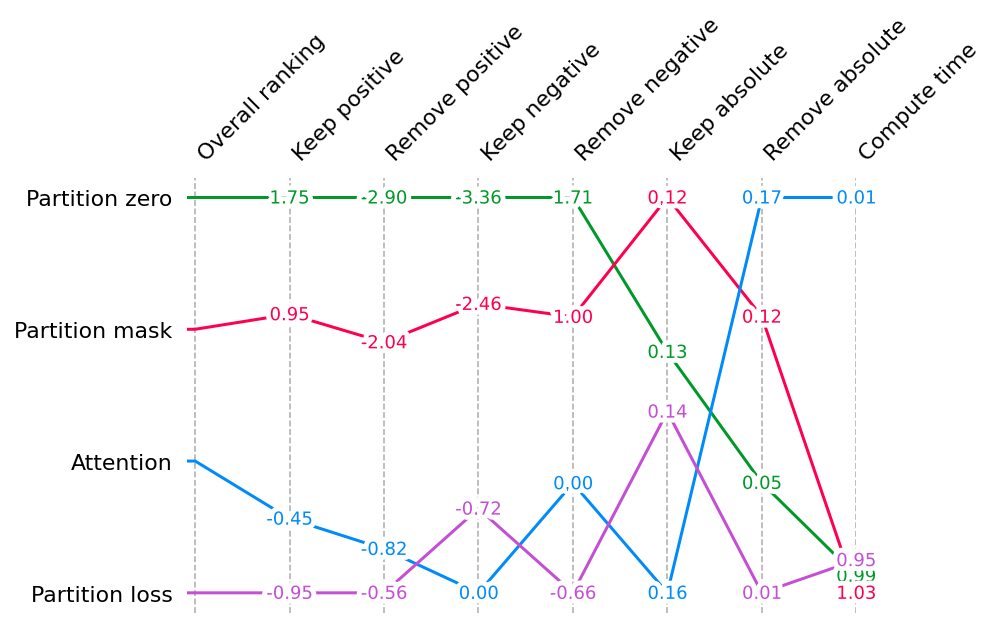

In [23]:
shap.plots.benchmark(sum(results.values(), []))

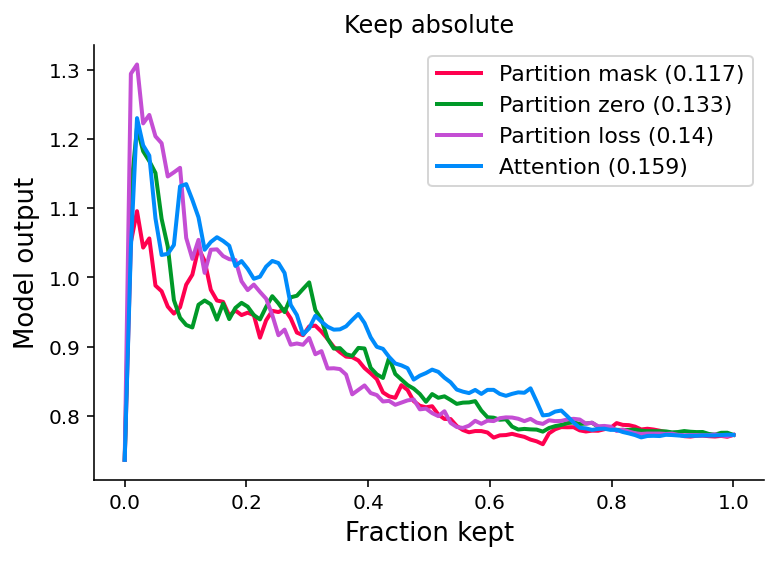

In [17]:
shap.plots.benchmark(results["keep absolute"])

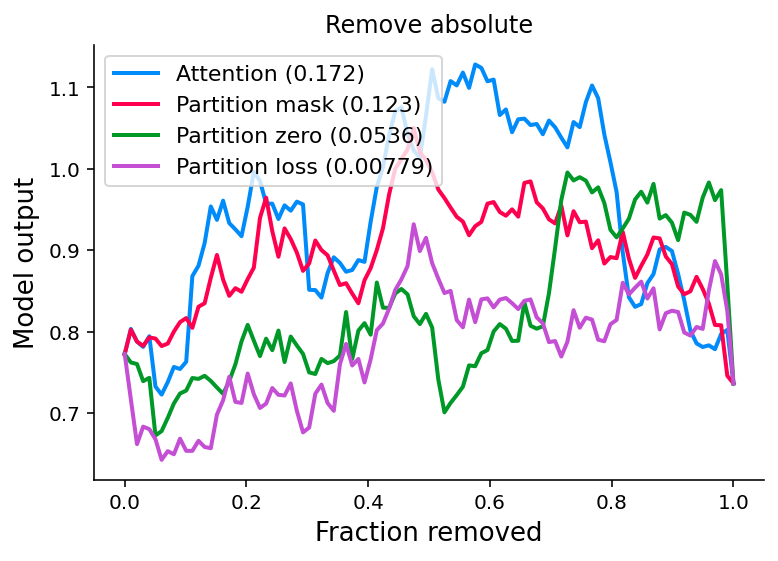

In [18]:
shap.plots.benchmark(results["remove absolute"])

In [17]:
loss_model(*cmasker_zero(False, "this is a test", [0]))

array([[0.16113283]])

In [24]:
loss_model(*cmasker_zero(True, data_100['text'][0], data_100['label'][0]))

array([1.61774395])

In [62]:
def f_str(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).cuda()
    print(tv)
    attention_mask = (tv!=0).type(torch.int64)
    outputs = model(tv, attention_mask=attention_mask, output_attentions=True)[0].detach().cpu().numpy()
    print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val
def f_str_positive(x):
    return f_str(x)[:, 1]


def f_ids(x):
    max_length = 128
    xt = torch.zeros(len(x), max_length, dtype=torch.int)
    for i in range(len(x)):
        l = min(max_length, len(x[i]))
        xt[i, :l] = torch.tensor(x[i][:max_length])
        xt[i, l-1] = 102 # end with ending tag
    tv = xt.cuda()
    print(tv)
    attention_mask = (tv!=0).type(torch.int64)
    outputsa = model(tv, attention_mask=attention_mask, output_attentions=True)
    outputs = outputsa[0].detach().cpu().numpy()
    print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val
def f_ids_positive(x):
    return f_ids(x)[:, 1]

In [63]:
f_ids_positive(*masker_zero(True, data_100["text"][0]))

tensor([[  101, 10386, 19558,  2003,  2241,  2588,  1996, 19558,  1016,  9160,
          1016,  1006,  2061,  2116,  1016,  2015,  1007,  2208,  1012,  2066,
          2087,  2678,  2208,  2357,  5691,  1010,  1045,  2052,  2360,  1996,
          3484,  2123,  1005,  1056, 17637,  2046,  1037,  2367,  5396,  2428,
          2092,  1012,  1998,  2008,  3632,  2005,  2023,  2028,  2205,  1010,
         16267,  1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,
          2045,  1005,  1055,  1037,  3492,  2146, 18877,  2029,  7607,  1998,
          4520,  1996, 18458,  2005,  1996,  2466,  1010,  1998,  1996,  8075,
          2479,  2006,  2029,  1037,  3213,  1006,  6688, 22993, 15319,  1007,
          1998,  2010,  2336,  1010,  2684, 24924,  1006,  9805,  2072, 22564,
          7556,  4213,  1007,  1998,  2365,  5342,  2080,  1006, 12022,  9152,
          6182, 11613,  1007,  2272,  2000,  2693,  2046,  1012,  1996, 11904,
          2123,  1005,  1056,  2298,  2035,  2205,  

array([0.28237328], dtype=float32)

In [64]:
f_str_positive([data_100["text"][0]])

tensor([[  101, 10386, 19558,  2003,  2241,  2588,  1996, 19558,  1016,  9160,
          1016,  1006,  2061,  2116,  1016,  2015,  1007,  2208,  1012,  2066,
          2087,  2678,  2208,  2357,  5691,  1010,  1045,  2052,  2360,  1996,
          3484,  2123,  1005,  1056, 17637,  2046,  1037,  2367,  5396,  2428,
          2092,  1012,  1998,  2008,  3632,  2005,  2023,  2028,  2205,  1010,
         16267,  1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,
          2045,  1005,  1055,  1037,  3492,  2146, 18877,  2029,  7607,  1998,
          4520,  1996, 18458,  2005,  1996,  2466,  1010,  1998,  1996,  8075,
          2479,  2006,  2029,  1037,  3213,  1006,  6688, 22993, 15319,  1007,
          1998,  2010,  2336,  1010,  2684, 24924,  1006,  9805,  2072, 22564,
          7556,  4213,  1007,  1998,  2365,  5342,  2080,  1006, 12022,  9152,
          6182, 11613,  1007,  2272,  2000,  2693,  2046,  1012,  1996, 11904,
          2123,  1005,  1056,  2298,  2035,  2205,  

array([0.28237328], dtype=float32)

In [30]:
exp = shap.Explainer(f_str_positive, tokenizer)
shap_values = exp(data_100['text'])

Partition explainer: 101it [02:12,  1.31s/it]                         


In [33]:
exp = shap.Explainer(f_ids_positive, masker_zero)
shap_values_z = exp(data_100['text'])

Partition explainer: 101it [01:40,  1.00it/s]                         


In [ ]:
for i in range(0):
    print("\n", data_100['text'][i])
    print(f_str_positive([data_100['text'][i]])[0])
    print(data_100['label'][i])

In [18]:
for mask_type, ordering in [("keep", "absolute")]:#, ("remove", "absolute")]:
    smasker = shap.benchmark.SequentialMasker(
        mask_type, ordering, cmasker_zero, f_ids_loss, data_100['text'], data_100['label'],
        batch_size=25
    )

    results[mask_type + " " + ordering] = [
#         smasker(shap_values_zero, name="Partition zero"),
#         smasker(shap_values_mask, name="Partition mask"),
#         smasker(shap_values_rand, name="Random"),
        smasker(shap_values_loss[0], name="Partition loss"),
        smasker(attention_values, name="Attention")
    ]
for b in results["keep absolute"]:
    b.value_sign = -1
# for b in results["remove absolute"]:
#     b.value_sign = 1

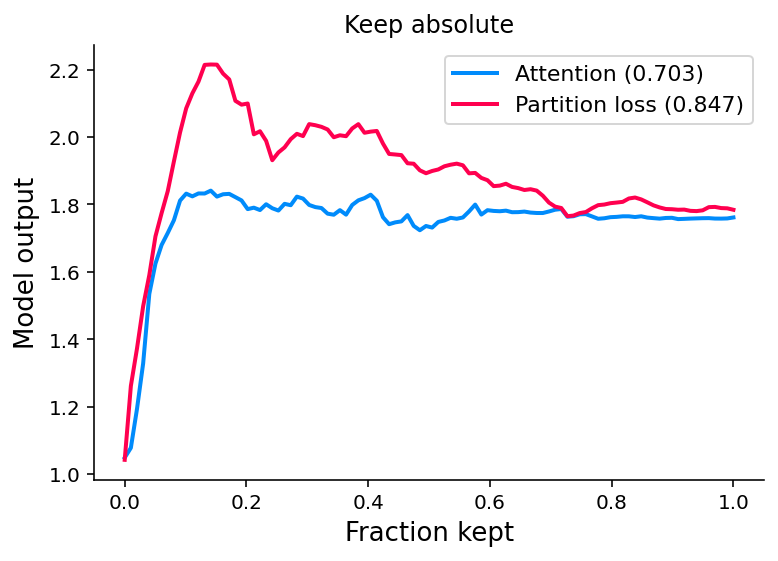

In [19]:
shap.plots.benchmark(results["keep absolute"])

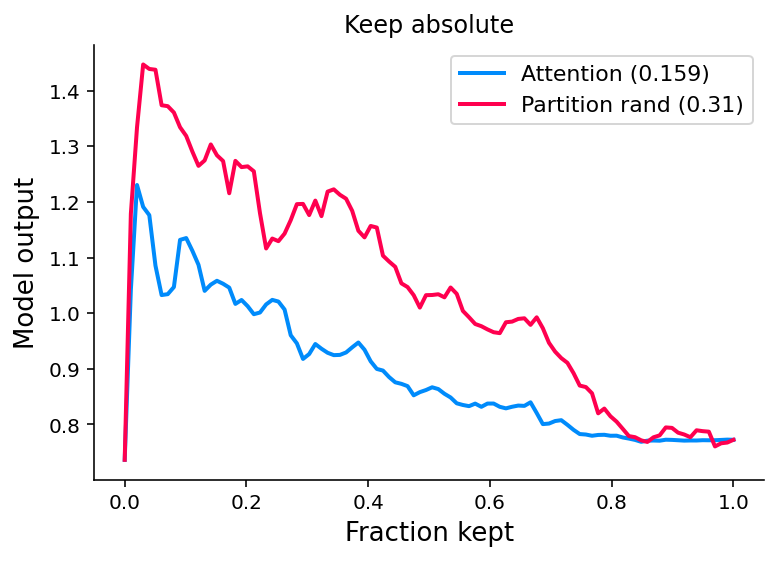

In [13]:
shap.plots.benchmark(results["keep absolute"])

In [22]:
remove_absolute = shap.benchmark.SequentialMasker(
    "remove", "absolute", cmasker_zero, loss_model, data_100['text'], data_100['label'],
    batch_size=25
)

ra_values = [
    remove_absolute(shap_values_zero, "Partition zero"),
    remove_absolute(shap_values_mask, "Partition mask"),
    remove_absolute(shap_values_loss, "Partition loss"),
    remove_absolute(attention_values, "Attention")
]

In [24]:
keep_positive = SequentialMasker(
    "keep", "positive", masker_zero, f_ids_positive, data_100['text'],
    batch_size=25
)

kp_values = [
    keep_positive(shap_values_zero, "Partition zero"),
    keep_positive(shap_values_mask, "Partition mask"),
    keep_positive(shap_values_loss, "Partition loss"),
    keep_positive(attention_values, "Attention")
]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


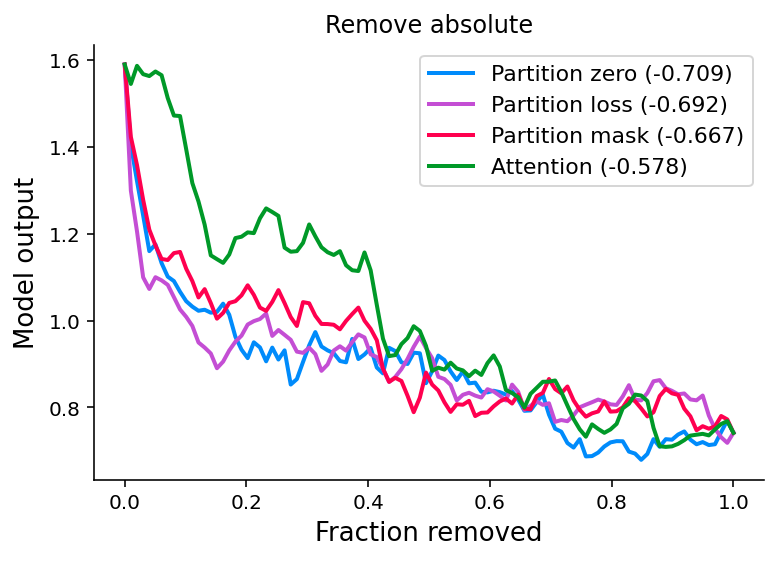

In [23]:
shap.plots.benchmark(ra_values)

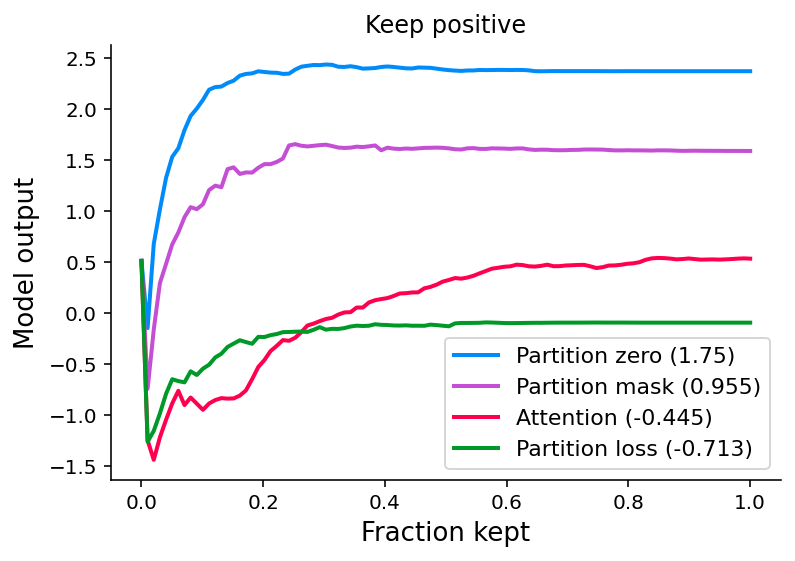

In [26]:
shap.plots.benchmark(kp_values)

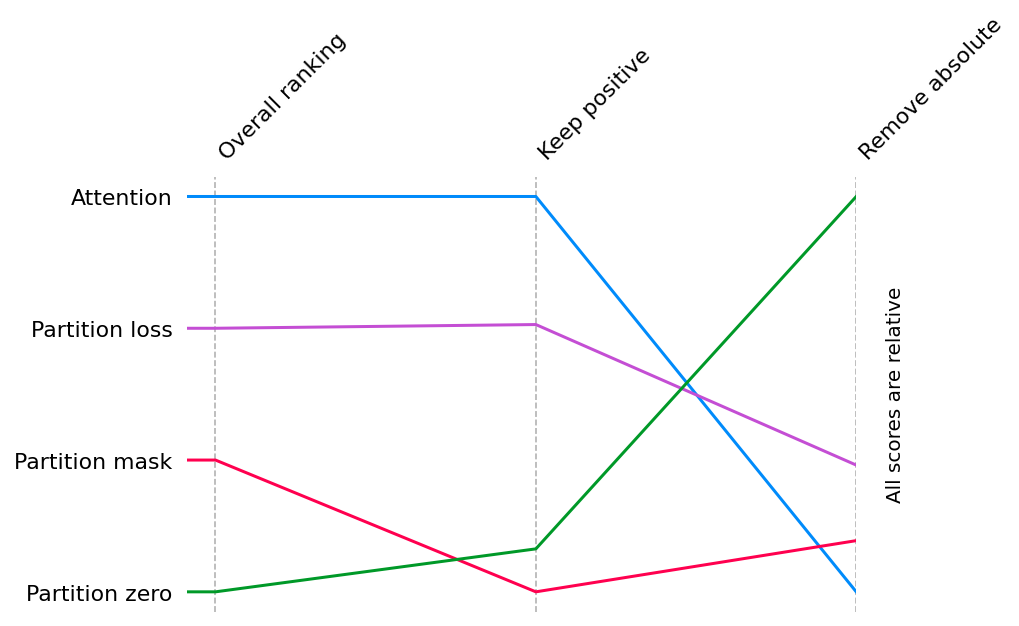

In [25]:
shap.plots.benchmark(ra_values + kp_values)

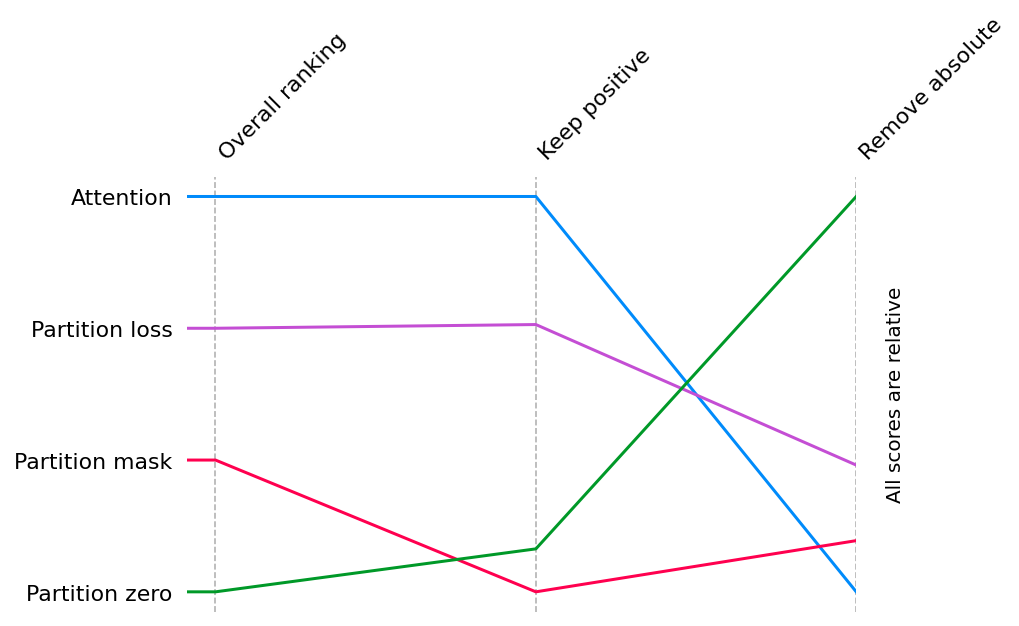

In [25]:
shap.plots.benchmark(ra_values + kp_values)

In [4]:

cmasker2 = shap.maskers.Composite(explainer_raw2.masker, shap.maskers.Fixed())

In [19]:
def loss_model(x, y):
    y = 2*np.array(y) - 1
    y *= -1
    return np.log(1 + np.exp(-(y*np.array(f_ids_positive(x).cpu().numpy()).T).T))
explainer_loss = shap.Explainer(loss_model, cmasker_zero)

In [29]:
shap_values_loss = explainer_loss(data['text'][inds[:1000]], data['emotion'][inds[:1000]])

Partition explainer: 1001it [15:48,  1.06it/s]                          


In [22]:
shap_values_zero = explainer_zero(data['text'][inds[:100]])

Partition explainer: 101it [01:30,  1.11it/s]                         


In [31]:
masker_zero.clustering("this is a test")

array([[0.        , 1.        , 0.33333333, 2.        ],
       [2.        , 3.        , 0.33333333, 2.        ],
       [4.        , 5.        , 0.33333333, 2.        ],
       [6.        , 7.        , 0.66666667, 4.        ],
       [9.        , 8.        , 1.        , 6.        ]])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


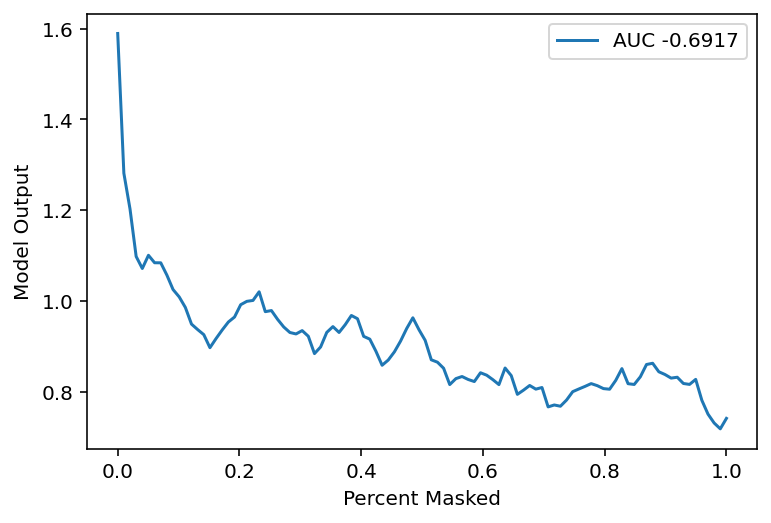

In [27]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    shap_values_loss[0],
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


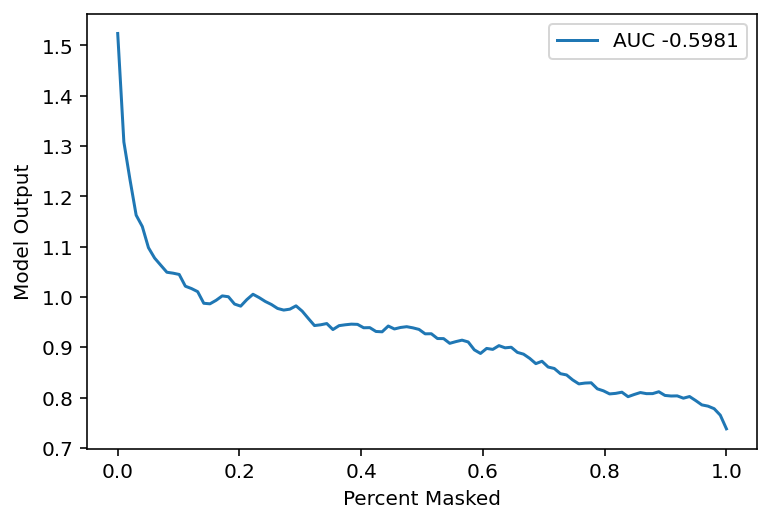

In [30]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    shap_values_loss[0],
    data['text'][inds[:1000]], data["emotion"][inds[:1000]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


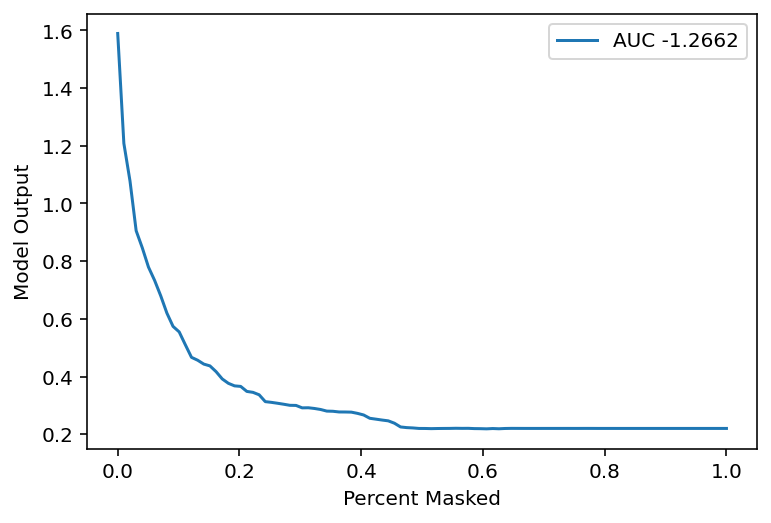

In [28]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "positive", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    shap_values_loss[0],
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


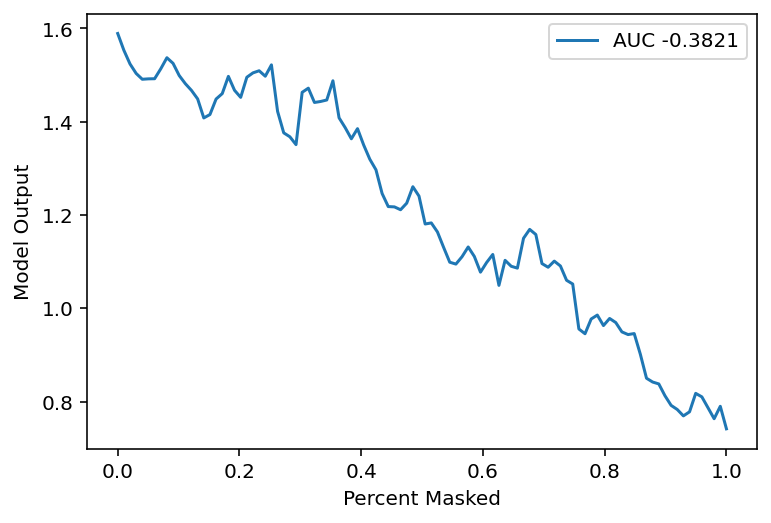

In [22]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    attention_values,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


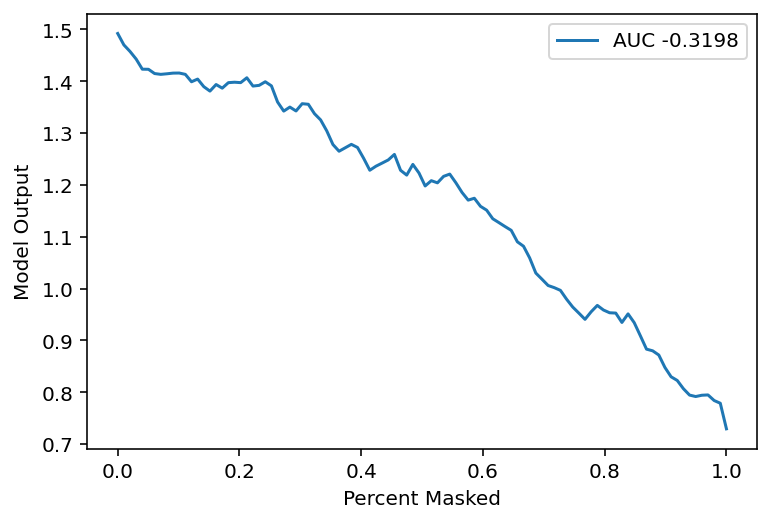

In [27]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    attention_values,
    data['text'][inds[:500]], data["emotion"][inds[:500]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


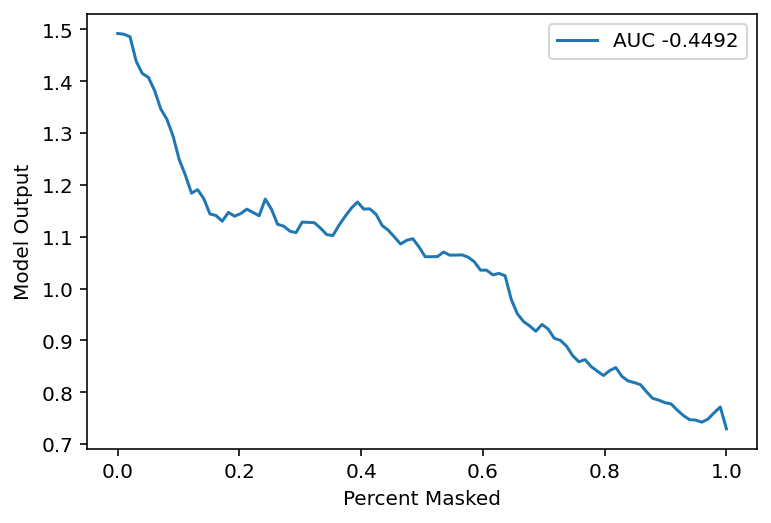

In [25]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    attention_values2,
    data['text'][inds[:500]], data["emotion"][inds[:500]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

In [150]:
import sklearn
class SequentialBenchmark():
    def __init__(self, name, xs, ys, sort_order, perturbation):
        self.name = name
        self.xs = xs
        self.ys = ys
        self.auc = sklearn.metrics.auc(np.linspace(0, 1, len(ys)), (ys-ys[0]))
        self.sort_order = sort_order
        self.perturbation = perturbation
    
    @property
    def metric_name(self):
        return self.perturbation + " " + self.sort_order
    
    @property
    def full_name(self):
        return self.name + " " + self.metric_name

In [187]:
b = SequentialBenchmark("Permutation", xs, ys, "absolute", "remove")

In [188]:
b2 = SequentialBenchmark("Attention", xs, ys+np.random.randn(len(ys))*0.1, "absolute", "remove")

In [189]:
b3 = SequentialBenchmark("Attention", xs, ys+np.random.randn(len(ys))*0.1, "absolute", "keep")

In [190]:
b4 = SequentialBenchmark("Permutation", xs, ys+np.random.randn(len(ys))*0.2, "absolute", "keep")

In [191]:
b5 = SequentialBenchmark("Partition", xs, ys+np.random.randn(len(ys))*0.2, "absolute", "keep")

In [192]:
b6 = SequentialBenchmark("Partition", xs, ys+np.random.randn(len(ys))*0.2, "absolute", "remove")

In [264]:
import matplotlib.pyplot as plt

xlabel_names = {
    "remove absolute": "Fraction removed",
    "remove positive": "Fraction removed",
    "remove negative": "Fraction removed",
    "keep absolute": "Fraction kept",
    "keep positive": "Fraction kept",
    "keep negative": "Fraction kept"
}

def plots_benchmark(benchmark):
    if hasattr(benchmark, "__len__"):
        
        # see if we have multiple metrics or just a single metric
        single_metric = True
        metric_name = None
        for b in benchmark:
            if metric_name is None:
                metric_name = b.metric_name
            elif metric_name != b.metric_name:
                single_metric = False
                break
        
        # plot a single metric benchmark result
        if single_metric:
            benchmark.sort(key=lambda b: b.auc)
            for i, b in enumerate(benchmark):
                plt.plot(
                    b.xs, b.ys,
                    color=shap.plots.colors.red_blue_circle(i/len(benchmark)),
                    linewidth=2,
                    label=b.name + f" ({b.auc:0.3})"
                )
                ax = plt.gca()
            ax.set_xlabel(xlabel_names[metric_name], fontsize=13)
            ax.set_ylabel("Model output", fontsize=13)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.legend(fontsize=11)
            plt.show()
        
        # plot a multi-metric benchmark result
        else:
            metrics = list(set(b.metric_name for b in benchmark))
            
            
            # compute normalized AUC's
            max_auc = {n: -np.inf for n in metrics}
            min_auc = {n: np.inf for n in metrics}
            for b in benchmark:
                if max_auc[b.metric_name] < b.auc:
                    max_auc[b.metric_name] = b.auc
                if min_auc[b.metric_name] > b.auc:
                    min_auc[b.metric_name] = b.auc
            norm_aucs = {}
            for b in benchmark:
                norm_aucs[b.full_name] = (b.auc - min_auc[b.metric_name]) / (max_auc[b.metric_name] - min_auc[b.metric_name])
            
            # compute the average auc for each method and sort by it 
            global_aucs = {}
            global_counts = {}
            for b in benchmark:
                global_aucs[b.name] = global_aucs.get(b.name, 0) + norm_aucs[b.full_name]
                global_counts[b.name] = global_counts.get(b.name, 0) + 1
            for k in global_aucs:
                global_aucs[k] /= global_counts[k]
            
            methods = list(set(b.name for b in benchmark))
            methods.sort(key=lambda method: -global_aucs[method])
            xs = [-0.03 * (len(methods) - 1)] + list(range(len(methods)))
            for i, method in enumerate(methods):
                scores = [1 - i/(len(methods)-1), 1 - i/(len(methods)-1)]
                for metric in metrics:
                    for b in benchmark:
                        if b.name == method and b.metric_name == metric:
                            scores.append(norm_aucs[b.full_name])
                plt.plot(
                    xs,
                    scores,
                    color=shap.plots.colors.red_blue_circle(i/len(methods)),
                    label=method
                )
                
            ax = plt.gca()
            ax.set_yticks([i / (len(methods) - 1) for i in range(0, len(methods))])
            ax.set_yticklabels(methods, rotation=0, fontsize=11)
            
            ax.set_xticks(np.arange(len(metrics) + 1))
            
            ax.set_xticklabels(['Overall ranking'] + [m.capitalize() for m in metrics], rotation=45, ha='left', fontsize=11)
            ax.xaxis.tick_top() 
            plt.grid(which='major', axis='x', linestyle='--')
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')
            ax.xaxis.set_ticks_position('none')
            plt.xlim(xs[0], len(methods)-1)
            plt.ylabel("\nAll scores are relative")
            ax.yaxis.set_label_position("right")  
            plt.show()
    
    # plot a single benchmark result
    else:
        plt.plot(
            benchmark.xs, benchmark.ys,
            color=shap.plots.colors.blue_rgb,
            linewidth=2,
            label=benchmark.name + f" ({benchmark.auc:0.3})"
        )
        ax = plt.gca()
        ax.set_xlabel(xlabel_names[benchmark.metric_name], fontsize=13)
        ax.set_ylabel("Model output", fontsize=13)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(fontsize=11)
        plt.show()

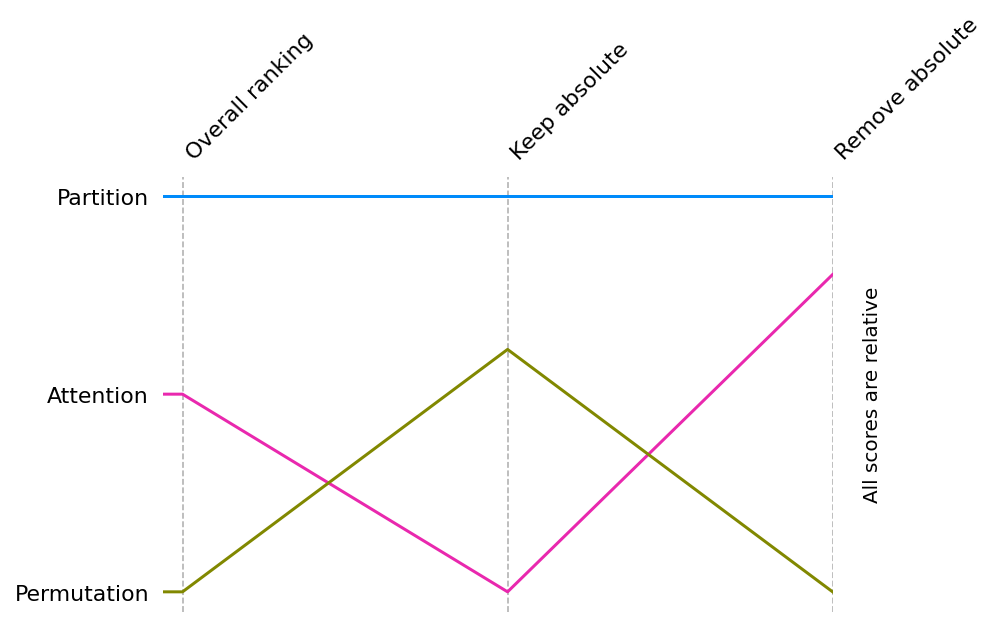

In [265]:
plots_benchmark([b, b2, b3, b4, b5, b6])

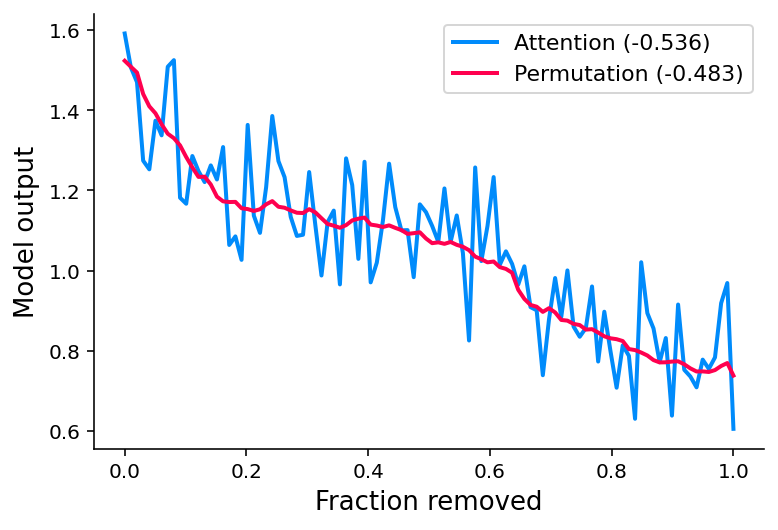

In [266]:
plots_benchmark([b, b2])

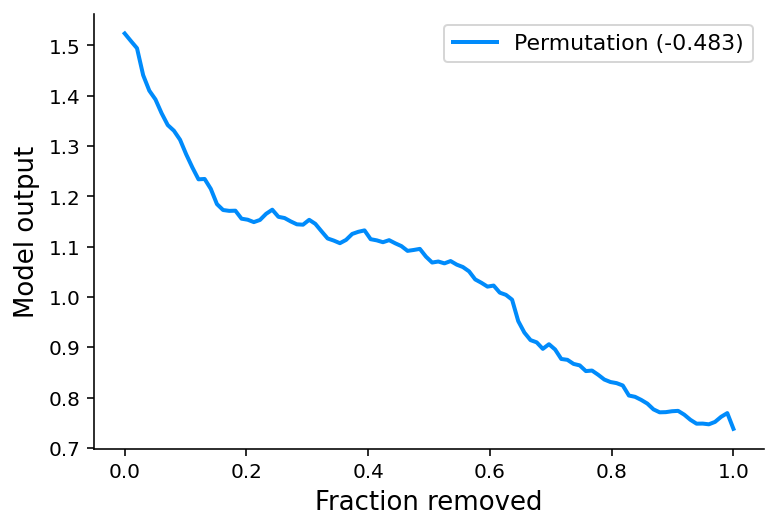

In [267]:
plots_benchmark(b)

In [119]:
plots_benchmark({"Partition explainer": b, "Attention weights": b2, "Attention weights": b3})

In [ ]:
loss_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "absolute", "remove"
)

output_perturbation = benchmark.perturbation.SequentialPerturbation(
    model, cmasker_zero, "absolute", "remove"
)

attributions = [asd, sdf, sdf]

benchmark = [loss_perturbation(k, attributions[k], *data, batch_size=25) for v in attributions] + \
    [output_perturbation(k, attributions[k], *data, batch_size=25) for v in attributions]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


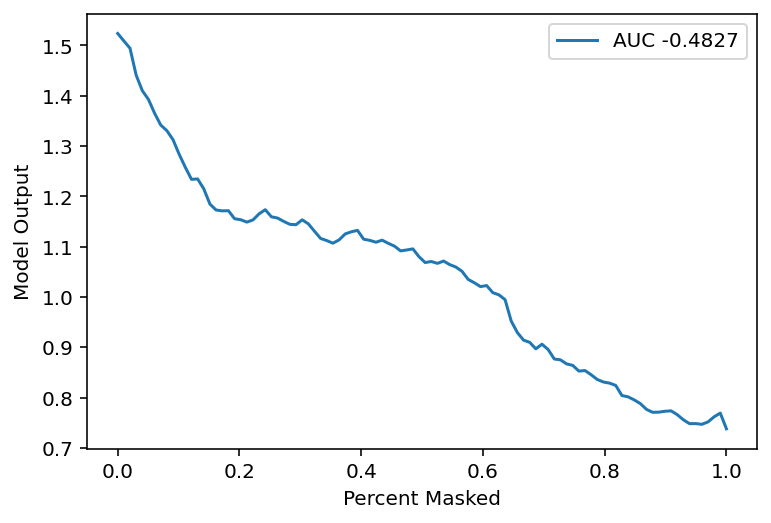

In [33]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker_zero, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    attention_values,
    data['text'][inds[:1000]], data["emotion"][inds[:1000]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

In [3]:
exp_loss = shap.Explainer(loss_model, cmasker)

In [5]:
loss_shap_values = exp_loss(data['text'][inds[:1]], data["emotion"][inds[:1]], batch_size=20)

Permutation explainer: 2it [00:27, 13.77s/it]               


IndexError: list index out of range

In [ ]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    loss_shap_values,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


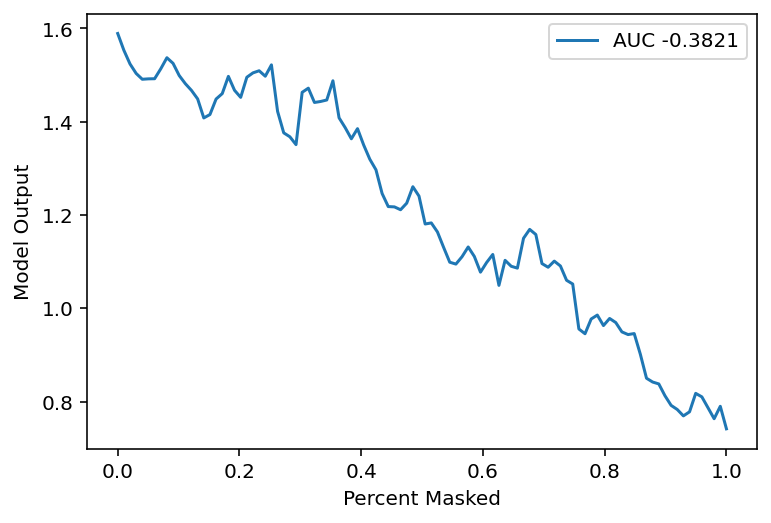

In [9]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    attention_values2,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


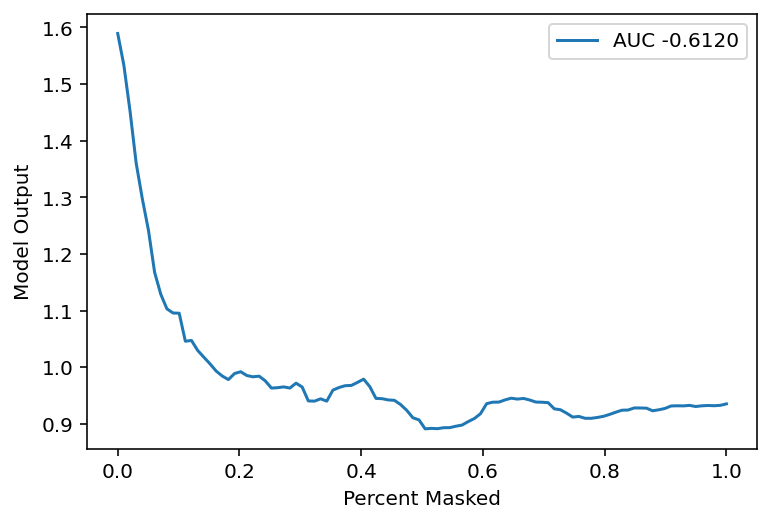

In [7]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker2, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    attention_values,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

In [14]:
losses = [loss_model(*cmasker(True, data['text'][inds[i]], data["emotion"][inds[i]]))[0] for i in range(100)]

In [16]:
np.mean(losses)

0.7723743133849119

In [7]:
shap_values_raw = explainer_raw(data["text"][inds[:100]])

Partition explainer: 101it [01:40,  1.01it/s]                         


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


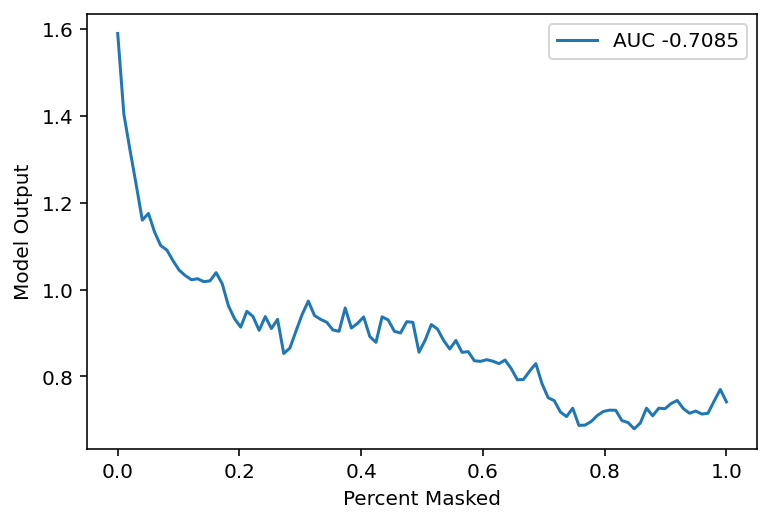

In [8]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    shap_values_raw,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

In [2]:
shap_values_raw2 = explainer_raw2(data["text"][inds[:100]])

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Partition explainer: 101it [01:43,  1.03s/it]                         


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


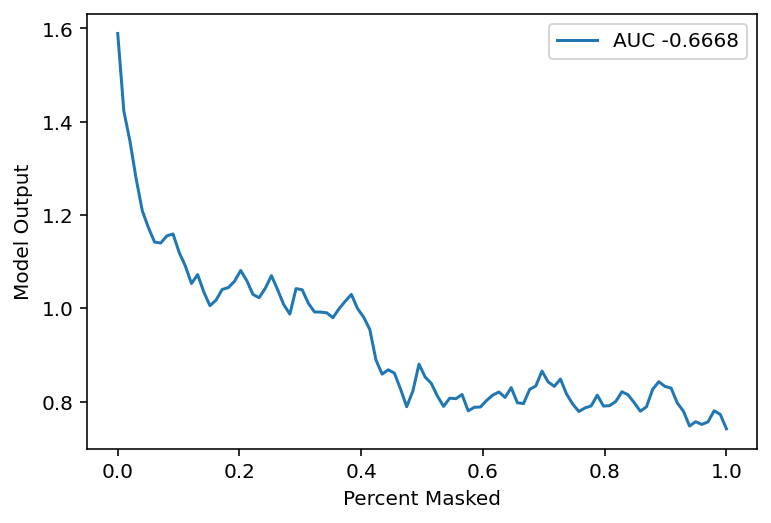

In [6]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    shap_values_raw2,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


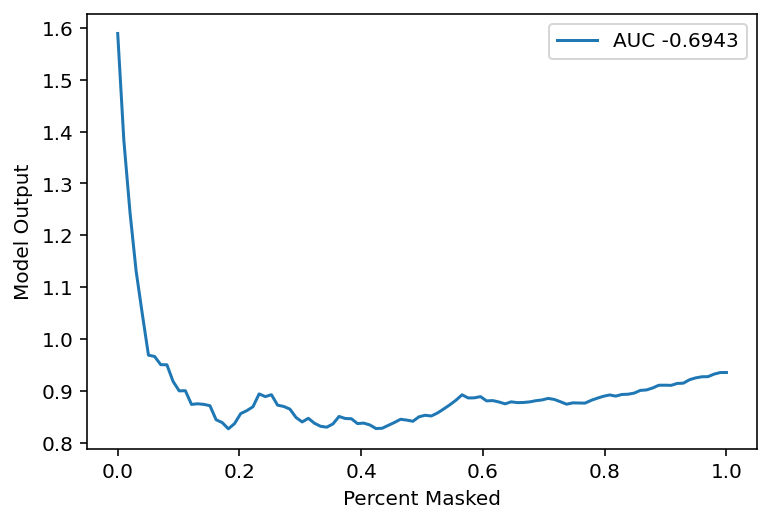

In [10]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker2, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    shap_values_raw2,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

In [ ]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker2, "absolute", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(
    shap_values_raw2,
    data['text'][inds[:100]], data["emotion"][inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

In [6]:
data["emotion"][inds[:100]].values

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1])

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import shap.benchmark as benchmark
import shap
import scipy as sp
#import nlp
import datasets
import torch
import transformers

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('max_colwidth', None)

### Load Data and Model

In [2]:
train = datasets.load_dataset("imdb", split="train")
test = datasets.load_dataset("imdb", split="test")

data={'text':train['text'],
     'emotion':train['label']}
    
data = pd.DataFrame(data)

Reusing dataset imdb (/home/slundberg/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)
Reusing dataset imdb (/home/slundberg/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


In [3]:
p = transformers.pipeline('sentiment-analysis')
tokenizer = p.tokenizer
model = p.model.cuda()


In [4]:
tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion",use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

### Class Label Mapping

In [5]:
# set mapping between label and id
id2label = model.config.id2label
label2id = model.config.label2id
labels = sorted(label2id, key=label2id.get)

### Define Score Function

In [6]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64)
    outputs = model(tv, attention_mask=attention_mask, output_attentions=True)[0].detach().cpu().numpy()
#     print(outputs.attentions)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val
f(["this is a test"])
def f_positive(x):
    return f(x)[:, 1]

In [7]:
x = ["this is a test"]
def f_raw(x):
#     print("x", x)
    max_length = 128
    xt = torch.zeros(len(x), max_length, dtype=torch.int)
    for i in range(len(x)):
        xt[i, :min(max_length, len(x[i]))] = torch.tensor(x[i, :max_length])
    tv = xt.cuda()
    attention_mask = (tv!=0).type(torch.int64)
    outputsa = model(tv, attention_mask=attention_mask, output_attentions=True)
    outputs = outputsa[0].detach().cpu()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val
def f_raw_positive(x):
    return f_raw(x)[:, 1]

In [8]:
masker_raw = shap.maskers.Text(tokenizer, output_type="ids", mask_token=0)

explainer_raw = shap.Explainer(f_raw_positive, masker_raw)

In [111]:
shap_values_raw = explainer_raw(data["text"][inds[:100]])

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Partition explainer: 101it [01:00,  1.67it/s]                         


In [34]:
import matplotlib.pyplot as plt

In [9]:
def attention_explain(x):
    assert len(x) == 1
    tv2 = torch.tensor([tokenizer.encode(v, max_length=10028, truncation=True) for v in x])
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64)
    outputsa = model(tv, attention_mask=attention_mask, output_attentions=True)
    nval = tv.cpu().numpy()
    out = np.zeros(tv2.shape[1])

    if nval[0,-1] != 0:
        l = 128
    else:
        l = np.where(tv.cpu().numpy() == 0)[1][0]
    vals = outputsa.attentions[0].mean(1).cpu().detach().numpy()[:,:l,:l][0].mean(0)
    out[:len(vals)] = vals
    return out

In [13]:
attention_values = np.array([attention_explain(data['text'][i:i+1]) for i in inds[:100]])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Create Explainer Object

In [10]:
explainer = shap.Explainer(f_joy, tokenizer)

### Run SHAP Explanation

In [49]:
shap_values = explainer(data['text'][0:100])

Partition explainer:  50%|█████     | 50/100 [01:34<02:42,  3.24s/it]

Partition explainer: 101it [03:15,  1.94s/it]                         


In [52]:
shap_values2 = explainer(data['text'][0:100], max_evals=100)

Partition explainer: 101it [00:48,  2.09it/s]                         


### Define Metrics (Sort Order & Perturbation Method)

In [17]:
sort_order = 'positive'
perturbation = 'keep'

In [46]:
explainer.model(["this is a test"])

array([-0.45922184], dtype=float32)

In [11]:
inds = np.arange(data.shape[0])
np.random.seed(0)
np.random.shuffle(inds)

In [90]:
data['emotion'][inds][1000:]

6217     1
18372    0
10064    1
6978     1
11483    1
        ..
13123    0
19648    0
9845     1
10799    1
2732     1
Name: emotion, Length: 24000, dtype: int64

In [93]:
data['emotion'].unique()

array([1, 0])

In [12]:
attention_values

NameError: name 'attention_values' is not defined

### Benchmark Explainer

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


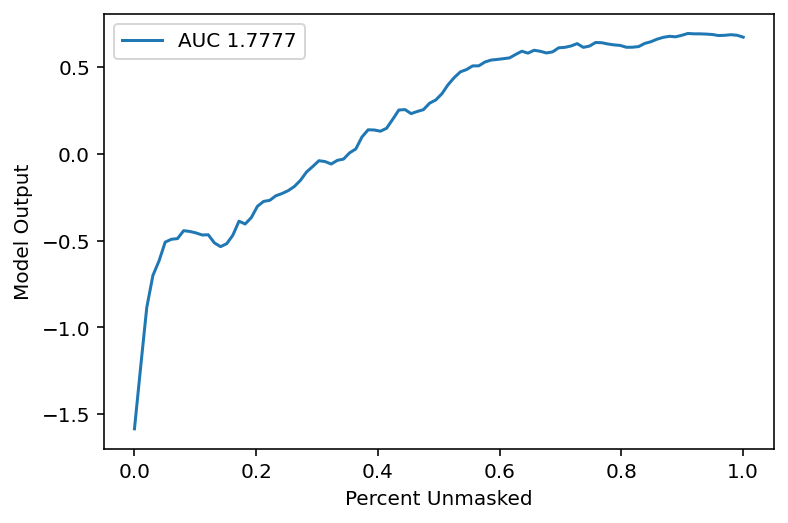

In [47]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, "absolute", perturbation
)
xs, ys, auc = sequential_perturbation.model_score(attention_values, data['text'][0:100], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

In [17]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker, "absolute", "keep"
)
xs, ys, auc = sequential_perturbation.model_score(
    attention_values,
    [(data['text'][i], data["emotion"][i]) for i in inds[:100]],
    batch_size=25
)
sequential_perturbation.plot(xs, ys, auc)

AssertionError: The number of passed args is incorrect!

In [16]:
def loss_model(x, y):
    y = 2*y - 1
    return np.log(1 + np.exp(-y*explainer_raw.model(x)))

In [ ]:
label_map = {}
for i in inds:
    label_map[data['text'][i]] = 

In [119]:
def np.log(1 + np.exp(50))

50.0

In [ ]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer_raw.model, explainer_raw.masker, "absolute", "keep"
)
xs, ys, auc = sequential_perturbation.model_score(attention_values, data['text'][inds[:100]], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

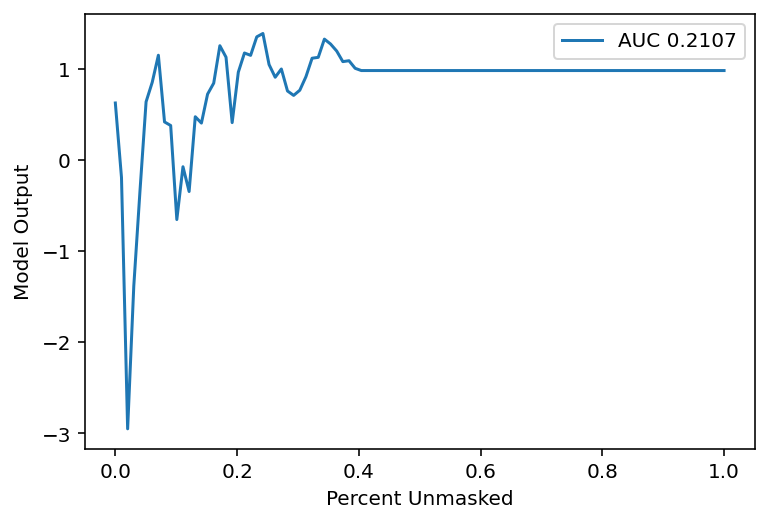

In [22]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer_raw.model, explainer_raw.masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values_raw[:1], data['text'][0:1], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

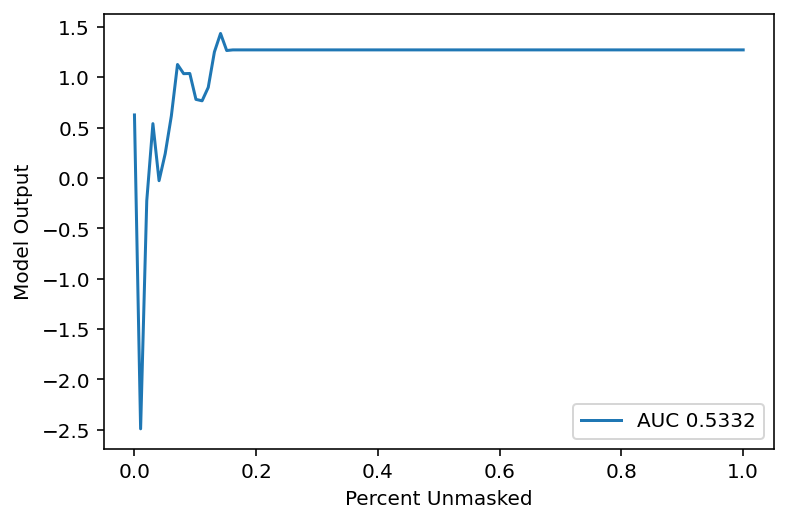

In [23]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer_raw.model, explainer_raw.masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values_raw[1:2], data['text'][1:2], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

In [14]:
class Composite(shap.maskers.Masker):
    def __init__(self, *maskers):
        self.maskers = maskers
        
        self.arg_counts = []
        self.total_args = 0
        for i, masker in enumerate(self.maskers):
            all_args = masker.__call__.__code__.co_argcount

            if masker.__call__.__defaults__ is not None:  #  in case there are no kwargs
                kwargs = len(masker.__call__.__defaults__)
            else:
                kwargs = 0
            num_args = all_args - kwargs - 2
            self.arg_counts.append(num_args) # -2 is for the self and mask arg
            self.total_args += num_args
    
    def shape(self, *args):
        assert len(args) == self.total_args, "The number of passed args is incorrect!"
        
        rows = None
        cols = 0
        pos = 0
        for i, masker in enumerate(self.maskers):
            if callable(masker.shape):
                shape = masker.shape(*args[pos:pos+self.arg_counts[i]])
            else:
                shape = masker.shape
            if rows is None:
                rows = shape[0]
            else:
                assert shape[1] == 0 or rows == shape[0], "All submaskers of a Composite masker must return the same number of rows!"
            cols += shape[1]
            pos += self.arg_counts[i]
        return rows, cols
    
    def __call__(self, mask, *args):
        assert len(args) == self.total_args, "The number of passed args is incorrect!"
        
        arg_pos = 0
        mask_pos = 0
        masked = []
        for i, masker in enumerate(self.maskers):
            masker_args = args[arg_pos:arg_pos+self.arg_counts[i]]
            if callable(masker.shape):
                shape = masker.shape(*masker_args)
            else:
                shape = masker.shape
            
            masked.extend(masker(mask[mask_pos:mask_pos+shape[1]], *masker_args))
            
            mask_pos += shape[1]
            arg_pos += self.arg_counts[i]
        return tuple(masked)
        
        
class Fixed(shap.maskers.Masker):
    """ This leaves the input unchanged during masking, and is used for things like scoring labels.

    Sometimes there are inputs to the model that we do not want to explain, but rather we want to
    consider them fixed. The primary example of this is when we explain the loss of the model using
    the labels. These "true" labels are inputs to the function we are explaining, but we don't want
    to attribute credit to them, instead we want to consider them fixed and assign all the credit to
    the model's input features. This is where the Fixed masker can help, since we can apply it to the
    label inputs.
    """
    def __init__(self):
        self.shape = (None, 0)

    def __call__(self, mask, x):
        return (x,)

        
cmasker = Composite(explainer_raw.masker, Fixed())

In [147]:
cmasker.total_args

2

In [148]:
cmasker(np.array([True, False, False, False, True, True]), "this is a test", 1)

(array([[ 101,    0,    0,    0, 3231,  102]]), 1)

In [128]:
all_args = myfunction.__code__.co_argcount

if myfunction.__defaults__ is not None:  #  in case there are no kwargs
  kwargs = len(myfunction.__defaults__)
else:
  kwargs = 0

print(all_args - kwargs)

NameError: name 'myfunction' is not defined

In [61]:
class TmpMasker(shap.maskers.Text):
    def __call__(self, m, x):
        print(m.sum(), m)
        out = explainer_raw.masker(m, x)
        print(out)
        return out
tmp_masker = TmpMasker()
tmp_masker.shape = explainer_raw.masker.shape
tmp_masker.mask_shapes = explainer_raw.masker.mask_shapes
tmp_masker.invariants = explainer_raw.masker.invariants

0 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False 

100 [False False False False False False False False False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
 False False False False  True  True  True  True False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fals

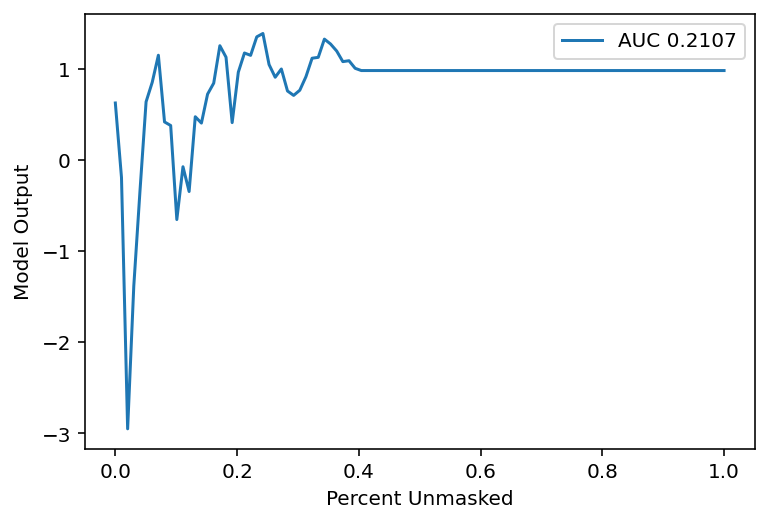

In [62]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer_raw.model, tmp_masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values_raw[0:1], data['text'][:1], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

In [45]:
def tmp(x):
    print(x.shape)
    print(str(x))
    return np.ones(len(x))

In [27]:
len(explainer_raw.masker.tokenizer(data['text'][0])['input_ids'])

200

In [36]:
m = explainer_raw.masker(np.zeros(200, dtype=np.bool), data['text'][0])[0]
m

array([[101,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [66]:
m = np.array([[ 101,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        0, 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  102]])
explainer_raw.model(m)

array([0.6258967], dtype=float32)

In [74]:
m = np.array([[ 101,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    678,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        0, 0,    0,    0,    0,    0,    ,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  102]])
f_raw(m)

tensor([[-1.2666, -1.1257, -2.8984, -0.6594, -2.0654, -3.4907]])

In [64]:
explainer_raw.model(m)

array([-0.16347387], dtype=float32)

In [37]:
m[0,1] = 2213

In [29]:
explainer_raw.model(*explainer_raw.masker(np.zeros(200, dtype=np.bool), data['text'][0]))

array([0.6258967], dtype=float32)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


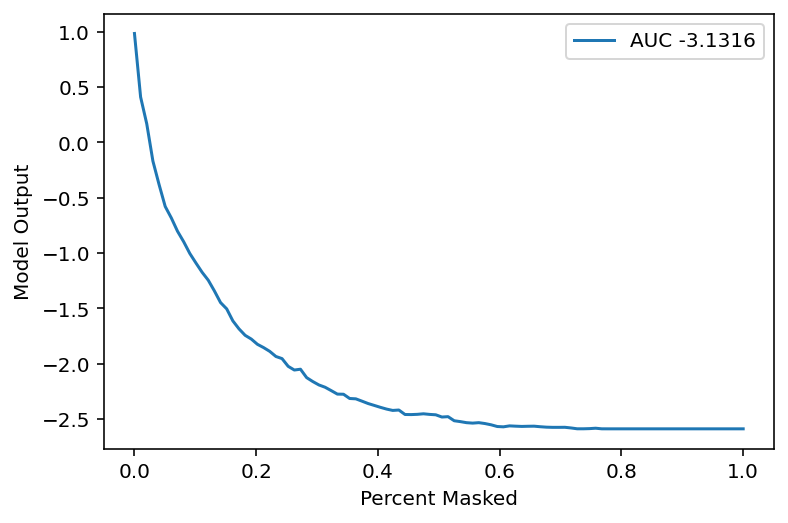

In [78]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    loss_model, cmasker, "positive", "remove"
)
xs, ys, auc = sequential_perturbation.model_score(shap_values_raw, data['text'][0:100], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


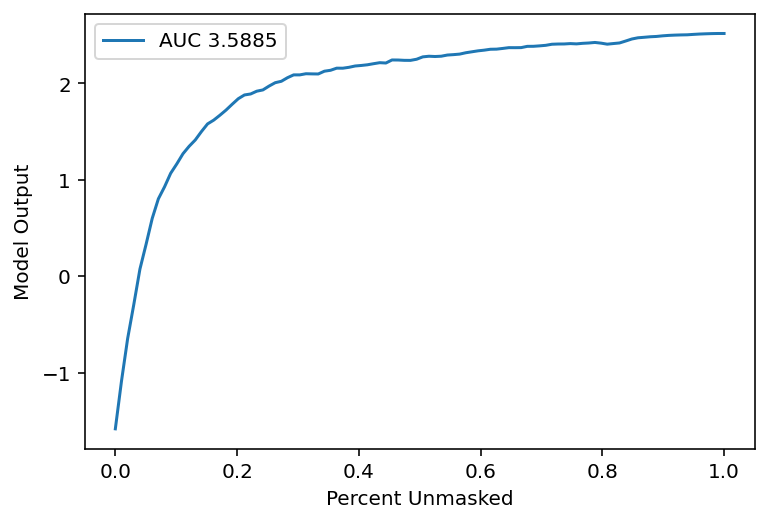

In [12]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values, data['text'][0:100], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


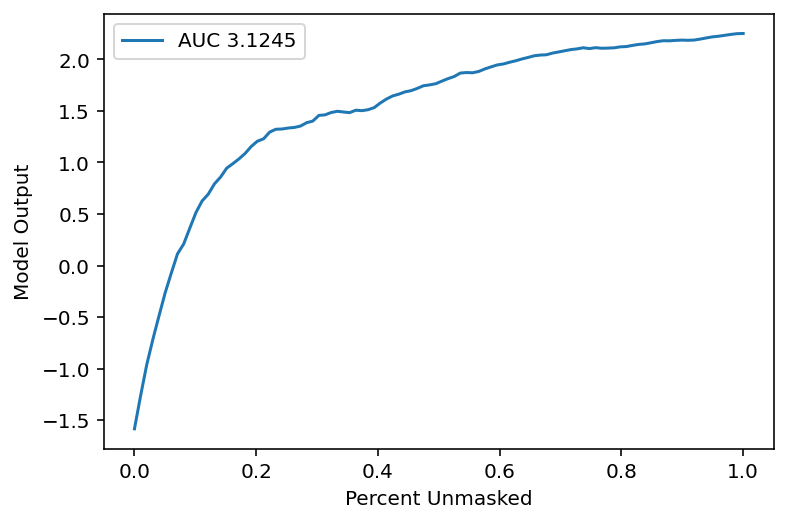

In [53]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values2, data['text'][0:100], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


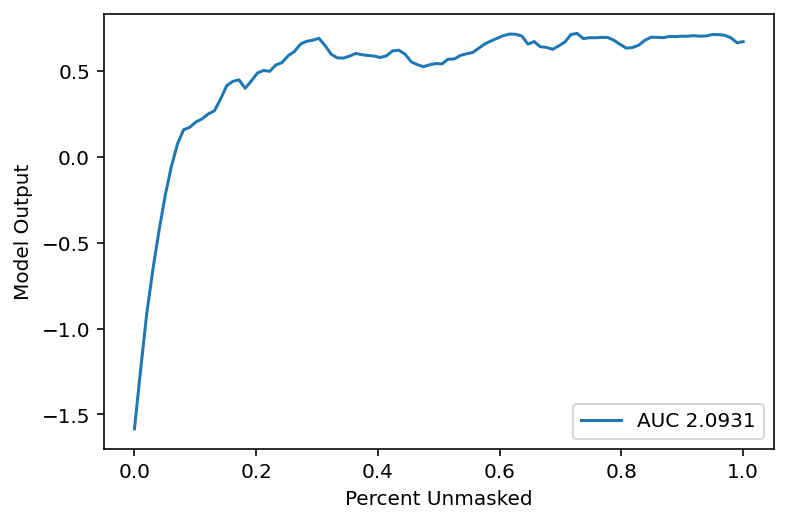

In [50]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, "absolute", perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values, data['text'][0:100], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


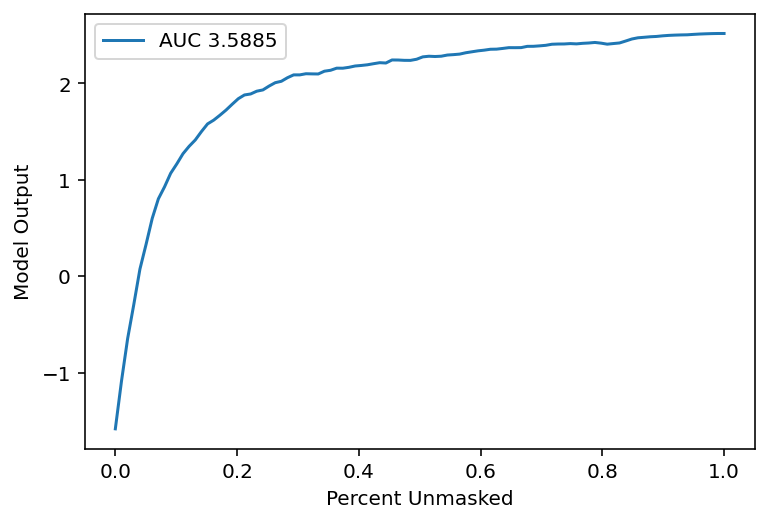

In [12]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values, data['text'][0:100], batch_size=25)
sequential_perturbation.plot(xs, ys, auc)

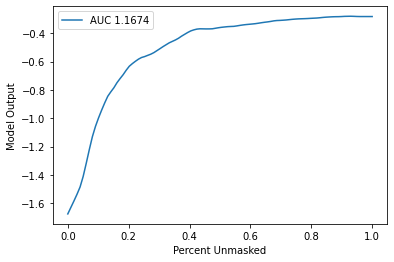

In [9]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(explainer.model, explainer.masker, sort_order, perturbation)
xs, ys, auc = sequential_perturbation.model_score(shap_values, data['text'][0:20])
sequential_perturbation.plot(xs, ys, auc)

In [10]:
sort_order = 'negative'
perturbation = 'keep'

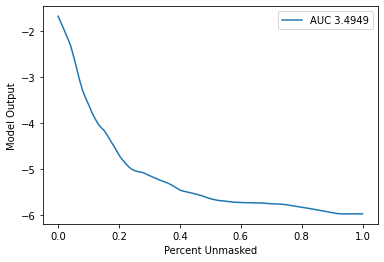

In [11]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(explainer.model, explainer.masker, sort_order, perturbation)
xs, ys, auc = sequential_perturbation.model_score(shap_values, data['text'][0:20])
sequential_perturbation.plot(xs, ys, auc)